# Experiments with policymodels

In this file specific policy variants are benchmarked against the 'no policy' alternative.
The policy variants all include set policies (wijkaanpak koop, woningcorp, normering nieuwbouw and efficiency) but vary in delivery mechanism: static, dynamic adaptive or mission oriented

- Sampling uncertainties on fr to district heat
- Better subsidy multiplier definition in adaptive policy

In [92]:
from ema_workbench import(Model, RealParameter,Constant,IntegerParameter,CategoricalParameter, TimeSeriesOutcome,
                          Policy, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.connectors.vensim import VensimModel  
from ema_workbench.em_framework.evaluators import LHS, SOBOL
import timeit
from ema_workbench import MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)
import pysd
import numpy.random
import pandas as pd
numpy.random.seed(123456789)

from ema_workbench.connectors.pysd_connector import PysdModel

### Simulation

In [93]:
wd =r'./model/20190726 - Policymodels_buurt_subsidies' # this is the directory where the model is located
model = VensimModel('BuiltEnvironmentTransitionModel', wd = wd , model_file='20190726_EnergyModel_Labour_Subsidy_StaticPolicy.vpm') # model contains only 1 subscript
ema_logging.log_to_stderr(ema_logging.INFO)   # we want to see what EMA is doing


<Logger EMA (DEBUG)>

### Policies
- Define policies for simulation

In [94]:
# Select policies

policies = [Policy('None', # turn on all policy switches
                   **{'SWITCH normering nieuwbouw':0,
                      'SWITCH elec efficiency':0,
                      'SWITCH wijkaanpak woningcorp':0,
                      'SWITCH wijkaanpak koop':0,
                     }),
            Policy('Static_20', model_file = '20190726_EnergyModel_Labour_Subsidy_StaticPolicy.vpm',
                  **{'subsidy percentage':0.2}),
            Policy('Dynamic_Adaptive_20', model_file = '20190726_EnergyModel_Labour_Subsidy_DynamicAdaptive.vpm',
                   **{'subsidy percentage':0.2,
                     'Doelstelling CO2 reductie 2050':0.95}),    
            Policy('Mission_R_and_D_20', model_file = '20190726_EnergyModel_Labour_Subsidy_MissionRandD.vpm',
                  **{'missie schaalfactor':1.25,
                    'subsidy percentage':0.2}),

            Policy('Static_40', model_file = '20190726_EnergyModel_Labour_Subsidy_StaticPolicy.vpm',
                  **{'subsidy percentage':0.4}),
            Policy('Dynamic_Adaptive_40', model_file = '20190726_EnergyModel_Labour_Subsidy_DynamicAdaptive.vpm',
                   **{'subsidy percentage':0.4,
                     'Doelstelling CO2 reductie 2050':0.95}),    
            Policy('Mission_R_and_D_40', model_file = '20190726_EnergyModel_Labour_Subsidy_MissionRandD.vpm',
                  **{'missie schaalfactor':1.25,
                    'subsidy percentage':0.4}),

            Policy('Static_60', model_file = '20190726_EnergyModel_Labour_Subsidy_StaticPolicy.vpm',
                  **{'subsidy percentage':0.6}),
            Policy('Dynamic_Adaptive_60', model_file = '20190726_EnergyModel_Labour_Subsidy_DynamicAdaptive.vpm',
                   **{'subsidy percentage':0.6,
                     'Doelstelling CO2 reductie 2050':0.95}),    
            Policy('Mission_R_and_D_60', model_file = '20190726_EnergyModel_Labour_Subsidy_MissionRandD.vpm',
                  **{'missie schaalfactor':1.25,
                    'subsidy percentage':0.6}),
            
              Policy('Static_80', model_file = '20190726_EnergyModel_Labour_Subsidy_StaticPolicy.vpm',
                  **{'subsidy percentage':0.8}),
            Policy('Dynamic_Adaptive_80', model_file = '20190726_EnergyModel_Labour_Subsidy_DynamicAdaptive.vpm',
                   **{'subsidy percentage':0.8,
                     'Doelstelling CO2 reductie 2050':0.95}),    
            Policy('Mission_R_and_D_80', model_file = '20190726_EnergyModel_Labour_Subsidy_MissionRandD.vpm',
                  **{'missie schaalfactor':1.25,
                    'subsidy percentage':0.8})]

### Uncertainties

In [95]:
# Specify uncertainties and aggregated outcomes

uncertainties = [RealParameter('fr innovation CoM',0.2,0.5),
                 RealParameter('groei nieuwbouw', 0.0088, 0.0097),
                 RealParameter('standard renovation rate', 0.0007,0.00085),
#                  RealParameter('policy time', 2020, 2025),
                 RealParameter('fr reduction renovation costs', 0.5, 0.8),
                 RealParameter('renovation costs label group 1', 8000, 12000),
                 RealParameter('renovation costs label group 2', 20000, 28000),
                 RealParameter('renovation costs label group 3', 30000, 36000),
                 RealParameter('renovation costs label group 4', 30000, 40000),
                 RealParameter('opschalings factor', 1, 1.1),
                 RealParameter('fraction subsidy over costs high income',0.1,0.3),
                 RealParameter('fraction subsidy over costs upper middle income',0.3,0.5),
                 RealParameter('fraction subsidy over costs lower middle income',0.5,0.7),
                 RealParameter('fraction subsidy over costs low income',0.7,0.9),
#                  RealParameter('subsidy',5000,40000),
                 RealParameter('groei gem elek gebruik',-0.01,0.01),            
                 RealParameter('fr to district heat wcorp no existing infrastructure',0.001, 0.1),
                 RealParameter('fr to district heat wcorp low existing infrastructure',0.3, 0.7),
                 RealParameter('fr to district heat wcorp high existing infrastructure',0.7, 1.0),
                 RealParameter('fr to district heat koop low existing infrastructure',0.1, 0.3),
                 RealParameter('fr to district heat koop high existing infrastructure',0.3, 0.6),
#                  RealParameter('fr to district heat koop no existing infrastructure',0, 0)
                ]

outcomes = [TimeSeriesOutcome('total cumulative subsidies awarded'),
            TimeSeriesOutcome('total subsidy awarded annually'),
            TimeSeriesOutcome('total renovated houses'),
            TimeSeriesOutcome('total renovated houses wcorp'),
            TimeSeriesOutcome('total renovated houses koop'),
            TimeSeriesOutcome('total renovated houses verhuur'),
#             TimeSeriesOutcome('total subsidy amount'),
            TimeSeriesOutcome('total costs'),
            TimeSeriesOutcome('total CO2 emission'),
            TimeSeriesOutcome('total warmte via elek'),
            TimeSeriesOutcome('total warmtenet'),
            TimeSeriesOutcome('total woningen gas'),
            TimeSeriesOutcome('total houses in model'),
            TimeSeriesOutcome('prijseffect schaarste manuren transitie GASnrELEK NL'),
            TimeSeriesOutcome('prijseffect schaarste manuren transitie GASnrWN NL'),
            TimeSeriesOutcome('totaal benodigde manuren transitie GebOmg GASnrELEK NL corp'),
            TimeSeriesOutcome('totaal benodigde manuren transitie GebOmg GASnrWN NL corp'),
            TimeSeriesOutcome('tekort manuren transitie GebOmg GASnrELEK NL'),
            TimeSeriesOutcome('tekort manuren transitie GebOmg GASnrWN NL'),
            TimeSeriesOutcome('beschikbare manuren transitie woningen GASnrWN NL'),
            TimeSeriesOutcome('beschikbare manuren transitie woningen GASnrELEK NL')
           ]

# ADD: 
# Set constants: override some of the defaults of the model
constants = [Constant('baseline CoM reduction',1), 
             Constant('CoM elec start', 0.45),
             Constant('CoM gas start', 1.791),
             Constant('CoM heat start', 0.0356),
             Constant('policy time', 2020)
            ]

In [96]:
model.uncertainties = uncertainties
model.outcomes = outcomes
model.constants = constants
nr_scenarios = 100

In [97]:
start_time = timeit.default_timer()

with MultiprocessingEvaluator(model) as evaluator:
    policy_results = evaluator.perform_experiments(scenarios=nr_scenarios, policies=policies) 

elapsed = timeit.default_timer() - start_time
print("Total time in minutes:", elapsed/60, "-- Time per run in seconds:", elapsed/(nr_scenarios*len(policies)))

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 13 policies * 1 model(s) = 1300 experiments
[MainProcess/INFO] 130 cases completed
[MainProcess/INFO] 260 cases completed
[MainProcess/INFO] 390 cases completed
[MainProcess/INFO] 520 cases completed
[MainProcess/INFO] 650 cases completed
[MainProcess/INFO] 780 cases completed
[MainProcess/INFO] 910 cases completed
[MainProcess/INFO] 1040 cases completed
[MainProcess/INFO] 1170 cases completed
[MainProcess/INFO] 1300 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[SpawnPoolWorker-14/INFO] finalizing
[SpawnPoolWorker-15/INFO] finalizing
[SpawnPoolWorker-16/INFO] finalizing
[SpawnPoolWorker-13/INFO] finalizing


Total time in minutes: 762.8492665358494 -- Time per run in seconds: 35.20842768626997


In [98]:
save_results(policy_results, r'C:\Users\LocalAdmin\Desktop\ETModel\results\20190726_experiments_policies_v2_100.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\LocalAdmin\Desktop\ETModel\results\20190726_experiments_policies_v2_100.tar.gz


### Visualization

In [99]:
from ema_workbench import(Model, RealParameter,Constant,IntegerParameter,CategoricalParameter, TimeSeriesOutcome, Policy, perform_experiments, ema_logging, save_results, load_results)

## Import specific plotting commands:  
import matplotlib.pyplot as plt
from ema_workbench.analysis.plotting import lines, plot_lines_with_envelopes, envelopes  
from ema_workbench.analysis.plotting_util import KDE, HIST, VIOLIN, BOXPLOT
import ema_workbench.analysis.pairs_plotting as pairs
import ema_workbench.analysis.plotting as emaplt

%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (20,8)

In [13]:
experiments, outcomes = policy_results

In [21]:
tu.return_experimented_policies(experiments=experiments)

{'Dynamic_Adaptive_20', 'Mission_R_and_D_20', 'None', 'Static_20'}

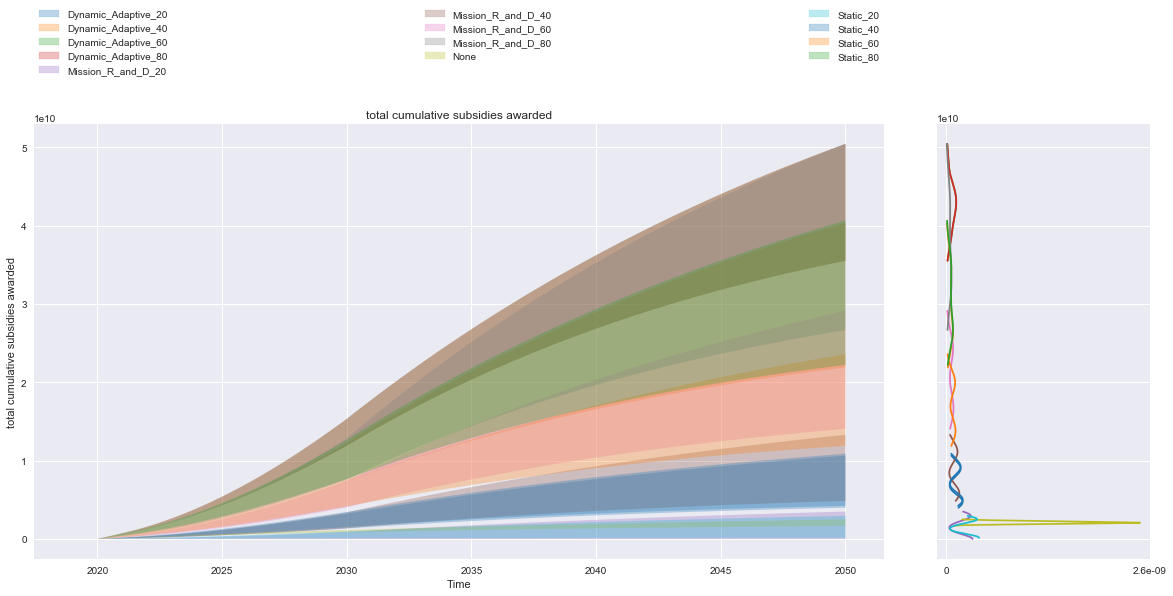

In [100]:
fig = envelopes(policy_results, outcomes_to_show=('total cumulative subsidies awarded'), fill=True , group_by='policy', density=KDE, legend=True, )

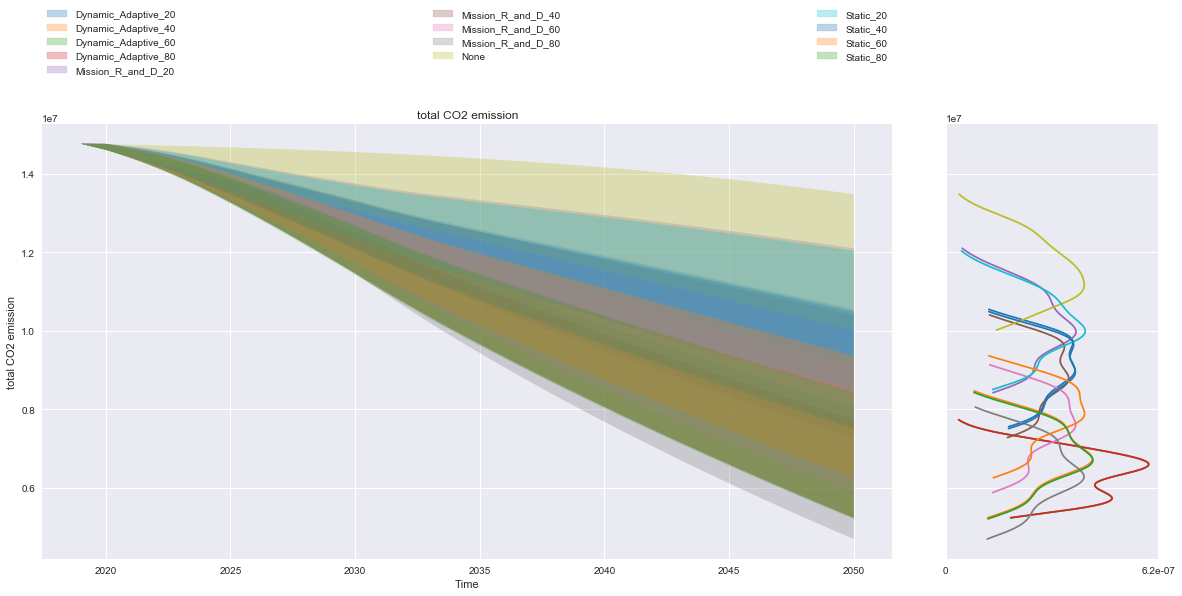

In [101]:
fig = envelopes(policy_results, outcomes_to_show=('total CO2 emission'), fill=True , group_by='policy', density=KDE)

In [ ]:
fig=lines(policy_results,outcomes_to_show='totaal benodigde manuren transitie GebOmg GASnrELEK NL corp', group_by='policy', density=KDE)

In [ ]:
fig = lines(policy_results, outcomes_to_show=('tekort manuren transitie GebOmg GASnrELEK NL'), group_by='policy', density=KDE)

In [ ]:
fig = lines(policy_results, outcomes_to_show=('total costs koop buurt'), group_by='policy', density=KDE)

In [ ]:
fig = envelopes(policy_results, outcomes_to_show=('total co2 heat'), fill=True , group_by='policy', density=KDE)

In [ ]:
fig = envelopes(policy_results, outcomes_to_show=('total warmte via elek'), fill=True , group_by='policy', density=KDE)

In [ ]:
fig = envelopes(policy_results, outcomes_to_show=('total woningen gas'), fill=True , group_by='policy', density=KDE)

In [ ]:
            TimeSeriesOutcome('total CO2 emission'),
            TimeSeriesOutcome('total co2 elec'),
            TimeSeriesOutcome('total co2 gas'),
            TimeSeriesOutcome('total co2 heat'),
            TimeSeriesOutcome('total warmte via elek'),
            TimeSeriesOutcome('total warmtenet'),
            TimeSeriesOutcome('total woningen gas')